In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Pytorch ImageFolder 객체에 맞도록 datafolder 구성 (레이블 필요한 경우)

In [ ]:
# filename 에 class 가 바로 대응된 dictionary 파일 읽어옴
import pickle

# dataset에서 file들 가져옴 
import os
import shutil

with open('/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pFileNameToClass.pickle','rb') as fw:
    pFileNameToClass = pickle.load(fw) # O(1) 로 바로 class 찾을 수 있다.

# 인쇄체 데이터 모은 폴더의 이미지들 file list 받음
path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/printed"
file_list = os.listdir(path) # 35765 -> augmentation 필요

# imageFolder 객체에 맞도록 datafolder 구성
pretrain_dir_path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pretrainDataset"
os.makedirs(pretrain_dir_path, exist_ok=True)

for filename in file_list:
    label = pFileNameToClass[filename]
    folder_path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pretrainDataset/" + str(label)
    os.makedirs(folder_path, exist_ok=True)
    shutil.move(path + '/' + filename, folder_path + '/' + filename)

## Pretrain_DataLoader

#### OSError: errno 5 input/output error 해결하기

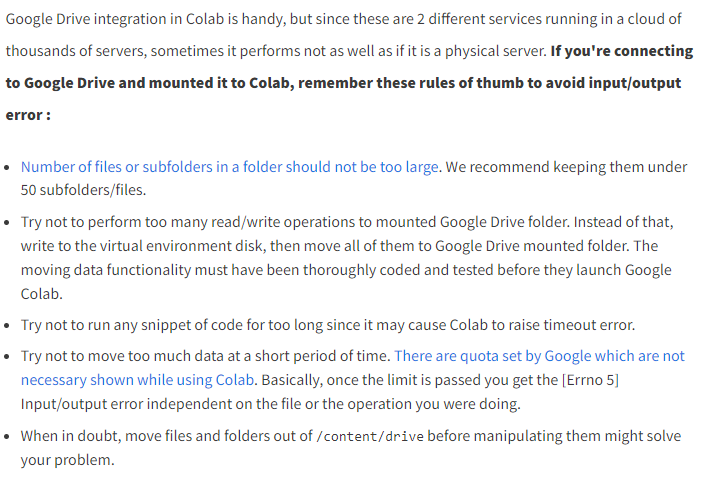

In [ ]:
import os
import shutil

# colab VM disc 사용
dir_path = "/content/data/printed"
os.makedirs(dir_path, exist_ok=True)

# 공유 드라이브의 데이터를 복사해 생성하기
driveFolder = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/printed'
newFolder = '/content/data/printed'
shutil.copytree(driveFolder, newFolder)

OSError: ignored

In [ ]:
path = "/content/data/printed"
file_list = os.listdir(path) # 35765 -> augmentation 필요
len(file_list)

0

### DataLoader

In [6]:
!unzip '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/transfer/augmented_withoutRotation_myData.zip' -d .

Archive:  /content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/transfer/augmented_withoutRotation_myData.zip
  inflating: ./data/augmentedData/2_00.png  
  inflating: ./data/augmentedData/0_1_100.png  
  inflating: ./data/augmentedData/1_12_53.png  
  inflating: ./data/augmentedData/16_34.png  
  inflating: ./data/augmentedData/1_1_033.png  
  inflating: ./data/augmentedData/10_56.png  
  inflating: ./data/augmentedData/0_12_81.png  
  inflating: ./data/augmentedData/14_059.png  
  inflating: ./data/augmentedData/4_44.png  
  inflating: ./data/augmentedData/1_14_025.png  
  inflating: ./data/augmentedData/1_084.png  
  inflating: ./data/augmentedData/14_077.png  
  inflating: ./data/augmentedData/0_11_26.png  
  inflating: ./data/augmentedData/1_2_15.png  
  inflating: ./data/augmentedData/1_3_12.png  
  inflating: ./data/augmentedData/12_49.png  
  inflating: ./data/augmentedData/0_1_013.png  
  inflating: ./data/augmentedData/1_1_021.png  
  infla

./data/augmentedData/1_016.png Size: (128, 128)


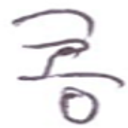

In [7]:
from PIL import Image, ImageOps

filePath = './data/augmentedData/1_016.png'
image=Image.open(filePath)
image.load()
imageSize = image.size
print(filePath, "Size:", imageSize)

display(image)

In [8]:
from PIL import Image
import os

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [9]:
class SyllablePrintedDataset(Dataset):
    def __init__(self, path, transform):        
        file_list = []
        for filename in os.listdir(path):
            fileName = path + '/' + filename
            file_list.append(fileName)        

        self.transform = transform
        self.dataset = []
        for img_path in file_list[:]:
            image = Image.open(img_path)
            img_transformed = self.transform(image)
            self.dataset.append(img_transformed)

    def __len__(self):
      return len(self.dataset)

    def __getitem__(self, index):
      return self.dataset[index]

In [10]:
# # dataloader test 
# transform = transforms.Compose([
#                                 transforms.Resize((64,64)),
#                                 transforms.RandomAffine(30),
#                                 transforms.ColorJitter(brightness=(0.2, 1.5), 
#                                                        contrast=(0.2, 3), 
#                                                        saturation=(0.2, 1.5)),
#                                 transforms.ToTensor(),
#                                 ])
# folderpath = '/content/preprocessed'
# dataset = SyllablePrintedDataset(folderpath, transform)

# print("학습에 사용하는 데이터 수 : ", dataset.__len__())

# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [11]:
# # dataloader test
# for imgs in dataloader: # 배치 단위로 iter
#   print(".")

## SelfAttentionGAN with Wasserstein Loss Model

In [12]:
import math
import sys
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

output_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/transfer'
os.makedirs(output_path, exist_ok=True)

In [13]:
class Opt:
    def __init__(self, epoch=500, batch_size=32, lr=0.0002, b1=0.5, b2=0.999, n_cpu=2, latent_dim=100, img_size=128, channels=3, n_critic=5, clip_value=0.01, sample_interval=400):
        self.n_epochs = epoch              # number of epochs of training
        self.batch_size = batch_size    # size of the batches
        self.lr = lr                    # adam: learning rate
        self.b1 = b1                    # adam: decay of first order momentum of gradient
        self.b2 = b2                    # adam: decay of first order momentum of gradient
        self.n_cpu = n_cpu              # number of cpu threads to use during batch generation
        self.latent_dim = latent_dim    # dimensionality of the latent space
        self.img_size = img_size        # size of each image dimension
        self.channels = channels        # number of image channels
        self.n_critic = n_critic        # number of training steps for discriminator per iter
        self.clip_value = clip_value    # lower and upper clip value for disc. weights
        self.sample_interval = sample_interval # interval between image sampling
opt = Opt() 

img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False

In [14]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [15]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

In [16]:
class Generator(nn.Module):
    """Generator."""

    def __init__(self, batch_size=opt.batch_size, image_size=opt.img_size, z_dim=opt.latent_dim, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size 
        layer1 = []
        layer2 = []
        layer3 = []
        layer4 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 4
        mult = 2 ** repeat_num # 8
        layer1.append(SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult

        layer2.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2)

        layer3.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())
        
        curr_dim = int(curr_dim / 2)

        layer4.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer4.append(nn.ReLU())
        
        curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)
        self.l4 = nn.Sequential(*layer4) # 이미지 크기가 64인 경우 
        # in_channels, out_channels, kernel_size, stride=1, padding=0
        last.append(nn.ConvTranspose2d(curr_dim, out_channels=3, kernel_size=4, stride=4, padding=0)) #
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 128, 'relu')


    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z) # 입력 : torch.Size([30, 100, 1, 1])
        # torch.Size([30, 512, 4, 4])
        out=self.l2(out)
        # torch.Size([30, 256, 8, 8])
        out=self.l3(out)
        #  torch.Size([30, 128, 16, 16])
        out,p1 = self.attn1(out)
        # torch.Size([30, 128, 16, 16]) 
        out=self.l4(out) 
        # torch.Size([30, 64, 32, 32]) 
        out=self.last(out)  
        # torch.Size([30, 3, 128, 128])
        return out, p1

In [17]:
class Discriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""

    def __init__(self, batch_size=opt.batch_size, image_size=opt.img_size, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(SpectralNorm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = conv_dim

        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.Conv2d(curr_dim, 1, 16))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(128, 'relu')


    def forward(self, x): 
        out = self.l1(x)
        # torch.Size([30, 64, 64, 64])
        out = self.l2(out)
        # torch.Size([30, 128, 32, 32])
        out,p1 = self.attn1(out)
        # torch.Size([30, 128, 32, 32])
        out = self.l3(out)
        # torch.Size([30, 256, 16, 16])
        out=self.last(out)
        # torch.Size([30, 1, 1, 1])
        return out.view(-1, 1), p1

In [18]:
# calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(opt.img_size,opt.img_size,opt.channels))

87924736/87910968 [==============================] - 0s 0us/step


In [19]:
import imageio
# # 최종 fid 계산용 이미지 리스트
# real_images = []

# path = '/content/data/augmentedData'
# for filename in os.listdir(path):
#   image = imageio.imread(path + '/' + filename)
#   real_images.append(image)
#   break

k = 2
p = 6

# 처음에만 load_path에서 읽어 오고 다른 경우 save_path에서 읽어오기 
# generator_load_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/model/SelfAttention_Wasserstein/generator.pth'
generator_load_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/model/transfer/generator.pth'
# discriminator_load_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/model/SelfAttention_Wasserstein/discriminator.pth'
discriminator_load_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/model/transfer/discriminator.pth'

generator_save_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/model/transfer/generator.pth'
discriminator_save_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/model/transfer/discriminator.pth'

# Initialize generator and discriminator
generator = Generator().cuda()
checkpoint_gen = torch.load(generator_load_path)
generator.load_state_dict(checkpoint_gen, strict=False)
# print(generator)

discriminator = Discriminator().cuda()
checkpoint_dis = torch.load(discriminator_load_path)
discriminator.load_state_dict(checkpoint_dis, strict=False)
# print(discriminator)


transform = transforms.Compose([
                                transforms.Resize((opt.img_size,opt.img_size)),
                                transforms.ToTensor(),
                                ])
folderpath = '/content/data/augmentedData'
dataset = SyllablePrintedDataset(folderpath, transform)
print("학습에 사용하는 데이터 수 : ", dataset.__len__())

dataloader = DataLoader(dataset, batch_size=opt.batch_size, shuffle=True)


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

fid_log, g_lossL, d_lossL = [], [], []

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

학습에 사용하는 데이터 수 :  2991


In [20]:
# ----------
#  Training
# ----------

batches_done = 0
for epoch in range(opt.n_epochs):
    for i, imgs in enumerate(dataloader):
        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input           # batch 수
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim)))) 

        # Generate a batch of images
        fake_imgs, gattn1 = generator(z)

        # Real images
        real_validity, dattnr1 = discriminator(real_imgs)
        # Fake images
        fake_validity, dattnf1= discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs, _ = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity, _ = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)
            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch+1, opt.n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
            )

            if batches_done % opt.sample_interval == 0: 
                save_image(fake_imgs.data[:25], "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/transfer/images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += opt.n_critic
      
    # epoch 끝날 때 마다 FID 계산 
    fake_images_list = []
    fake_imgs = fake_imgs.detach().cpu().numpy()
    for fake_img in fake_imgs:
      fake_img = np.transpose(fake_img, (1, 2, 0))
      fake_img =(fake_img * 255).astype(np.uint8)
      fake_images_list.append(fake_img)

    real_images_list = []
    real_imgs = imgs.detach().cpu().numpy()
    for real_img in real_imgs:
      real_img = np.transpose(real_img, (1, 2, 0))
      real_img =(real_img * 255).astype(np.uint8)
      real_images_list.append(real_img)
    
    real_images = np.array(real_images_list)
    fake_images = np.array(fake_images_list)

    shuffle(real_images)
    # convert integer to floating point values
    real_img = real_images.astype('float32')
    fake_img = fake_images.astype('float32')

    # pre-process images
    real_img = preprocess_input(real_img)
    fake_img = preprocess_input(fake_img)

    # calculate fid
    fid = calculate_fid(model, real_img, fake_img)
    print('FID: %.3f' % fid)
    fid_log.append(fid)


    # FID 및 모델 파라미터 저장
    torch.save(generator.state_dict(), generator_save_path)
    torch.save(discriminator.state_dict(), discriminator_save_path)
    g_lossL.append(g_loss)
    d_lossL.append(d_loss)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[Epoch 193/500] [Batch 66/94] [D loss: -7.255647] [G loss: -2.198878]
[Epoch 193/500] [Batch 71/94] [D loss: -8.093708] [G loss: -1.576430]
[Epoch 193/500] [Batch 76/94] [D loss: -7.167903] [G loss: -1.209502]
[Epoch 193/500] [Batch 81/94] [D loss: -6.052469] [G loss: -1.237638]
[Epoch 193/500] [Batch 86/94] [D loss: -6.376813] [G loss: -1.717079]
[Epoch 193/500] [Batch 91/94] [D loss: -7.148551] [G loss: -1.492440]
FID: 1794.343
[Epoch 194/500] [Batch 1/94] [D loss: -6.982892] [G loss: -1.070788]
[Epoch 194/500] [Batch 6/94] [D loss: -8.494989] [G loss: -1.192549]
[Epoch 194/500] [Batch 11/94] [D loss: -8.483304] [G loss: -0.476834]
[Epoch 194/500] [Batch 16/94] [D loss: -7.632123] [G loss: -0.896963]
[Epoch 194/500] [Batch 21/94] [D loss: -5.651937] [G loss: -1.480849]
[Epoch 194/500] [Batch 26/94] [D loss: -6.738587] [G loss: -1.055764]
[Epoch 194/500] [Batch 31/94] [D loss: -7.709980] [G loss: -1.518971]
[Epoch 194/500] [Batch 36/94] [D loss: -7.

KeyboardInterrupt: ignored

In [21]:
import csv
with open('/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/transfer/loss/FID.csv', 'a', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(fid_log) 

In [22]:
import csv 
with open('/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/transfer/loss/loss.csv', 'a', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(g_lossL) 
    writer.writerow(d_lossL) 

#### 생성한 데이터 확인

In [23]:
z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim)))) 
fake_imgs, gattn1 = generator(z)
gattn1.shape # batch x (16x16) x (16x16)

torch.Size([32, 256, 256])

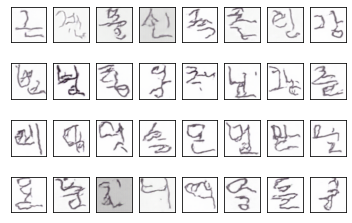

In [24]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(20,20))
z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim)))) 
fake_imgs, gattn1 = generator(z)

fake_imgs = fake_imgs.detach().cpu().numpy()

for i, img in enumerate(fake_imgs):
  plt.subplot(4,8,i+1)
  img = np.transpose(img, (1, 2, 0))
  img = (img * 255).astype(np.uint8)
  plt.imshow(img)
  plt.xticks([]);plt.yticks([])
plt.show()

#### 생성한 이미지 저장

In [25]:
dirpath = '/content/GANresult'
if not os.path.exists(dirpath):
    os.makedirs(dirpath)

for batch in range(100): # 3200개 데이터 수집
  z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim)))) 
  fake_imgs, gattn1 = generator(z)
  fake_imgs = fake_imgs.detach().cpu().numpy()

  for iter, img in enumerate(fake_imgs):
    img = np.transpose(img, (1, 2, 0))
    img = (img * 255).astype(np.uint8)
    plt.imsave(f'{dirpath}/{batch}_{iter}.png',img)

In [26]:
import zipfile

new_zips= zipfile.ZipFile('GANresult.zip', 'w') # 
num_zipfile = 0

for folder, subfolders, files in os.walk('/content/GANresult'): 
    for file in files:
        new_zips.write(os.path.join(folder, file), os.path.relpath(os.path.join(folder,file), './'), compress_type = zipfile.ZIP_DEFLATED)
        num_zipfile += 1
new_zips.close()

print("저장한 데이터 수 : ", num_zipfile)

저장한 데이터 수 :  3200


In [27]:
import shutil

savePath = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/transfer'

shutil.move('GANresult.zip', savePath)

'/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/transfer/GANresult.zip'

### github 커밋

In [28]:
MY_GOOGLE_DRIVE_PATH = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital"
%cd "{MY_GOOGLE_DRIVE_PATH}"

/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital


In [29]:
!git config --global user.email dkwjd0824@khu.ac.kr  # 이메일 입력 ex) qhrqufdlek@naver.com
!git config --global user.name  hyeneung #깃헙 아이디 입력 ex)luckydipper
!git pull

Already up to date.


In [30]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)

	modified:   GAN/Parsing.ipynb
	modified:   GAN/WGAN_DIV.ipynb
	modified:   GAN/model/SelfAttention_Wasserstein/discriminator.pth
	modified:   GAN/model/SelfAttention_Wasserstein/generator.pth
	modified:   GAN/myDataDataset.ipynb
	modified:   GAN/selfAttentionGAN.ipynb
	modified:   GAN/transferLearning.ipynb
	deleted:    object_detection/1_input_img/1001.png
	deleted:    object_detection/main.ipynb
	deleted:    object_detection/model/CRNN.ipynb
	deleted:    object_detection/model/ctpn_model.ipynb
	deleted:    object_detection/model/ctpn_model.py
	deleted:    object_detection/model/ctpn_utils.py
	deleted:    object_detection/model/dataset.py
	deleted:    object_detection/model/error_imgs.

In [ ]:
!git add GAN/selfAttentionGAN.ipynb

In [ ]:
!git commit -m"[ADD] modelSave and Load"

[main d3b8107] [ADD] modelSave and Load
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite GAN/selfAttentionGAN.ipynb (84%)


In [ ]:
!git push

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 2.14 KiB | 168.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/PILGI-Analog-To-Digital/Analog-PILGI-to-DIgital.git
   2e4617c..d3b8107  main -> main
